### Creación de imágenes con GANs - modelo 2

In [73]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, Model

In [74]:
image_size = 64
latent_size = 128
batch_size = 256
epochs = 25
lr = 0.0001

In [75]:
def build_discriminator():
    model = tf.keras.Sequential([
        layers.Input(shape=(image_size, image_size, 3)),
        layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        
        layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        
        layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        
        layers.Conv2D(512, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        
        layers.Conv2D(1, (4, 4), padding='valid', use_bias=False),
        layers.Flatten(),
        layers.Activation('sigmoid')
    ])
    return model

In [76]:
def build_generator():
    model = tf.keras.Sequential([
        layers.Input(shape=(latent_size,)),
        layers.Reshape((1, 1, latent_size)),
        
        layers.Conv2DTranspose(512, (4, 4), strides=(1, 1), padding='valid', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        
        layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        
        layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        
        layers.Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.Activation('tanh')
    ])
    return model

In [77]:
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 32, 32, 64)        3072      
                                                                 
 batch_normalization_36 (Ba  (None, 32, 32, 64)        256       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 conv2d_26 (Conv2D)          (None, 16, 16, 128)       131072    
                                                                 
 batch_normalization_37 (Ba  (None, 16, 16, 128)       512       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_21 (LeakyReLU)  (None, 16, 16, 128)      

In [78]:
generator = build_generator()
generator.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_4 (Reshape)         (None, 1, 1, 128)         0         
                                                                 
 conv2d_transpose_20 (Conv2  (None, 4, 4, 512)         1048576   
 DTranspose)                                                     
                                                                 
 batch_normalization_40 (Ba  (None, 4, 4, 512)         2048      
 tchNormalization)                                               
                                                                 
 re_lu_16 (ReLU)             (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_21 (Conv2  (None, 8, 8, 256)         2097152   
 DTranspose)                                                     
                                                     

In [79]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

In [80]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [81]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [82]:
generator_optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.5)

In [83]:
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, latent_size])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [84]:
data_dir = r"C:\Users\PC\OneDrive\Documentos\UNIVERSIDAD\CME\GMV\datos\train\train"

In [85]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=(image_size, image_size),
    batch_size=batch_size,
    labels="inferred",  # Opcional: infiere automáticamente las etiquetas de las clases
    label_mode="int",  # Opcional: especifica que las etiquetas son valores enteros
    color_mode="rgb",  # Opcional: establece el modo de color a RGB
    shuffle=True,  # Opcional: mezcla el conjunto de datos
)

# Aplicar normalización a las imágenes en el conjunto de datos
train_dataset = train_dataset.map(lambda x, y: (x - 127.5) / 127.5)


Found 16854 files belonging to 33 classes.


Aquí sí que hemos considerado que hay distintas categorías dentro de nuestras imágenes originales, además de haber cambiado ligeramente los parámetros de la GANs.

In [86]:
for epoch in range(epochs):
    for image_batch in train_dataset:
        train_step(image_batch)

Vemos que aún así necesitamos una alta capacidad de computación, y que de nuevo hemos necesitado algo más de 6 horas para entrenar al modelo.

In [87]:
num_samples = 9
sample_noise = tf.random.normal([num_samples, latent_size])
sample_images = generator(sample_noise)
sample_images = 0.5 * sample_images + 0.5  # Denormalize
sample_images = np.clip(sample_images, 0, 1)  # Clip values to [0, 1]

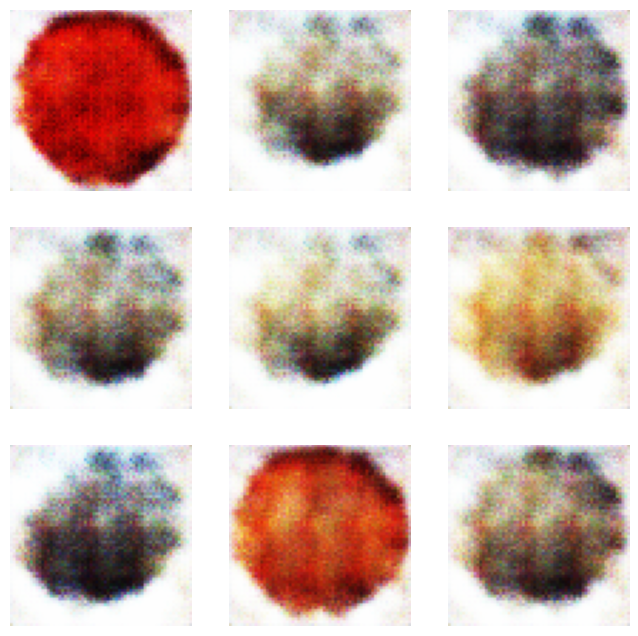

In [88]:
fig, axs = plt.subplots(3, 3, figsize=(8, 8))
for i in range(num_samples):
    axs[i // 3, i % 3].imshow(sample_images[i])
    axs[i // 3, i % 3].axis('off')
plt.show()